# Classification on Fashion-MNIST
In this notebook, we show how to use `SFR` for classification on the Fashion-MNIST data set.

In [1]:
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from IPython.display import clear_output
from netcal.metrics import ECE
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

sys.path.append("..")  # Adds higher directory to python modules path.

import likelihoods
import priors
import sfr

Let's fix the random seed for reproducibility and use GPU if it's available.

In [2]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

## Fashion-MNIST data set

The Fashion-MNIST data set is an image classification problem with $80,000$ inputs $\mathbf{x}_i \in \mathbb{R}^{28 \times 28}$ (i.e. single channel images) and outputs ${y}_i \in \{0, \dots, 9\}$. The original inputs are integers but we transform them into floating point numbers.

Let's load the Fashion-MNIST train/test data sets and normalize them.

In [18]:
batch_size = 128
train_val_split = 0.8
in_channels = 1  # 1 for MNIST/Fashion-MNIST

Set debug to only use 500 data points.

In [19]:
debug = False  # if debug=True only use 500 data points

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))]
)
ds_train = torchvision.datasets.FashionMNIST(
    "data", download=True, train=True, transform=transform
)
ds_test = torchvision.datasets.FashionMNIST(
    "data", download=True, train=False, transform=transform
)

Split the train data set into train/validation sets and create data loaders.

In [21]:
output_dim = len(ds_train.classes)
num_data = len(ds_train) if not debug else 500

idxs = np.random.permutation(num_data)
split_idx = int(train_val_split * num_data)

train_loader = DataLoader(
    Subset(ds_train, idxs[:split_idx]), batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    Subset(ds_train, idxs[split_idx + 1 :]), batch_size=1024, shuffle=True
)
if debug:
    test_loader = DataLoader(
        Subset(ds_train, idxs[split_idx + 1 :]),
        batch_size=1024,
        shuffle=True,
        pin_memory=True,
    )
else:
    test_loader = DataLoader(ds_test, batch_size=1024, shuffle=True, pin_memory=True)

## Neural network 

Given the data set $\mathcal{D} = \{(\mathbf{x}_{i} , \mathbf{y}_{i})\}_{i=1}^{N}$, we want to approximate the function $f$ with a neural network $f_\mathbf{w}: \mathbb{R} \to \mathbb{R}$ with weights $\mathbf{w} \in \mathbb{R}^{P}$.
It is common to traing the neural network weights $\mathbf{w}$ to minimize the (regularized) empirical risk,
\begin{equation}
  \mathbf{w}^{*} = 
  \arg \min_{\mathbf{w}} \mathcal{L}(\mathcal{D},\mathbf{w}) =
  \arg \min_{\mathbf{w}} \textstyle\sum_{i=1}^{N} \ell(f_\mathbf{w}(\mathbf{x}_{i}), y_i) + \mathcal{R}(\mathbf{w}).
\end{equation}
where $l(f_\mathbf{w}(\mathbf{x}_{i}), y_i) = -\log p(y \mid f_\mathbf{w}(\mathbf{x}_{i}))$ and the regularizer $\mathcal{R}(\mathbf{w}) = \frac{\delta}{2}\| \mathbf{w}\|^{2}_{2}$.
We can view this as the maximum a~posteriori (MAP) solution to a Bayesian objective, where the first term $l(f_\mathbf{w}(\mathbf{x}_{i}), y_i)$ represents the log likelihood and the regularization weight takes the role of a prior precision parameter, $p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \delta^{-1} \mathbf{I})$.

Let's start by creating a neural network.

In [7]:
class CIFAR10Net(nn.Module):
    def __init__(self, in_channels: int = 3, n_out: int = 10, use_tanh: bool = False):
        super().__init__()
        self.output_size = n_out
        activ = nn.Tanh if use_tanh else nn.ReLU

        self.cnn_block = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=64,
                            kernel_size=(5, 5),
                            stride=(1, 1),
                        ),
                    ),
                    ("relu1", nn.ReLU()),
                    (
                        "maxpool1",
                        nn.Sequential(
                            nn.ZeroPad2d((0, 1, 0, 1)),
                            nn.MaxPool2d(kernel_size=3, stride=2),
                        ),
                    ),
                    (
                        "conv2",
                        nn.Conv2d(
                            in_channels=64,
                            out_channels=96,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                        ),
                    ),
                    ("relu2", nn.ReLU()),
                    (
                        "maxpool2",
                        nn.Sequential(
                            nn.ZeroPad2d((0, 1, 0, 1)),
                            nn.MaxPool2d(kernel_size=3, stride=2),
                        ),
                    ),
                    (
                        "conv3",
                        nn.Conv2d(
                            in_channels=96,
                            out_channels=128,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=(1, 1),
                        ),
                    ),
                    ("relu3", nn.ReLU()),
                    (
                        "maxpool3",
                        nn.Sequential(
                            nn.ZeroPad2d((1, 1, 1, 1)),
                            nn.MaxPool2d(kernel_size=3, stride=2),
                        ),
                    ),
                ]
            )
        )
        self.lin_block = nn.Sequential(
            OrderedDict(
                [
                    ("flatten", nn.Flatten()),
                    ("dense1", nn.Linear(in_features=3 * 3 * 128, out_features=512)),
                    ("activ1", activ()),
                    ("dense2", nn.Linear(in_features=512, out_features=256)),
                    ("activ2", activ()),
                    (
                        "dense3",
                        nn.Linear(in_features=256, out_features=self.output_size),
                    ),
                ]
            )
        )
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.constant_(module.bias, 0.0)
                nn.init.xavier_normal_(module.weight)

            if isinstance(module, nn.Linear):
                nn.init.constant_(module.bias, 0.0)
                nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        x = self.cnn_block(x)
        out = self.lin_block(x)
        return out


network = CIFAR10Net(in_channels=in_channels)

Making predictions with `SFR` depends on the loss function as it encodes our likelihood and prior.
As such, we instantiate `SFR` by passing it a prior and a likelihood.

We use a Gaussian prior over the weights as it correspondes to a weight decay regulariser.

In [8]:
prior_precision = 0.004

prior = priors.Gaussian(params=network.parameters, prior_precision=prior_precision)

We use a Categorical likelihood, which corresponds to using the cross entropy loss.

In [9]:
likelihood = likelihoods.CategoricalLh(EPS=0.0)

In [10]:
model = sfr.SFR(
    network=network,
    prior=prior,
    likelihood=likelihood,
    output_dim=output_dim,
    num_inducing=2048,
    dual_batch_size=1024,  # this reduces the memory required for computing dual parameters
    jitter=1e-4,
)

We can now train the network using our loss function `SFR.loss()`.

In [11]:
num_epochs = 100
learning_rate = 1e-4

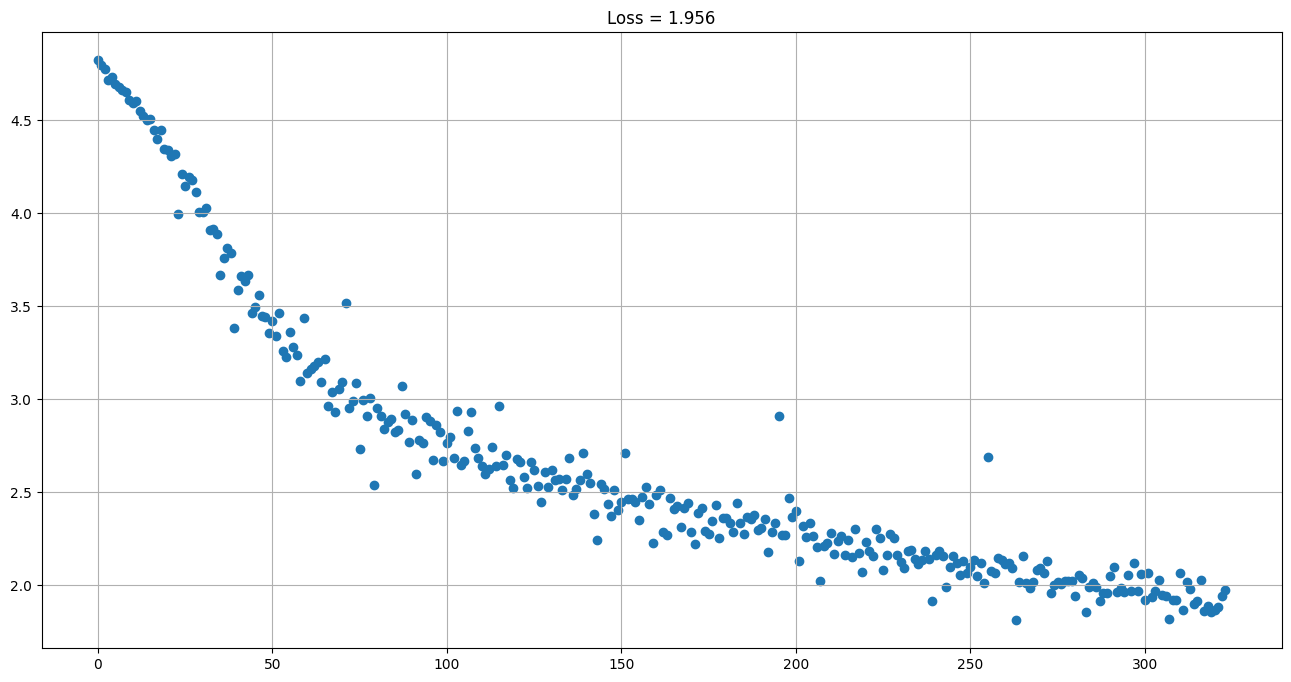

In [12]:
def train(
    model: sfr.SFR,
    data_loader: DataLoader,
    num_epochs: int = 1000,
    batch_size: int = 16,
    learning_rate: float = 1e-3,
) -> dict:
    model.train()
    optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=learning_rate)
    loss_history = []
    for epoch_idx in range(num_epochs):
        for batch_idx, batch in enumerate(data_loader):
            x, y = batch
            loss = model.loss(x, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.detach().numpy())

        if epoch_idx % 20 == 0:
            clear_output(True)
            plt.figure(figsize=[16, 8])
            plt.subplot()
            plt.title("Loss = %.3f" % np.mean(loss_history[-32:]))
            losses = np.array(loss_history)
            losses_idx = np.arange(len(losses))
            plt.scatter(losses_idx, losses)
            plt.grid()
            plt.show()

    return {"loss": loss_history}


metrics = train(
    model=model,
    data_loader=train_loader,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
)

Let's create a helper function which can calculate the NLPD/accuracy/ECE of the NN and SFR on the test data.

In [13]:
@torch.no_grad()
def evaluate(model: sfr.SFR, data_loader: DataLoader, sfr_pred: bool = False):
    model.eval()
    probs, targets, val_losses = [], [], []
    dtype = next(model.parameters()).dtype  # because change NN from float to double
    for data, target in data_loader:
        data = data.to(dtype).to(device)
        target = target.to(device)
        if sfr_pred:  # predict with SFR
            probs.append(model(data.to(device))[0])
        else:  # predict with NN
            probs.append(torch.softmax(model.network(data), dim=-1))
        targets.append(target)
        val_losses.append(model.loss(data, target))

    val_loss = torch.mean(torch.stack(val_losses, 0)).cpu().numpy().item()
    targets = torch.cat(targets, dim=0).cpu().numpy()
    probs = torch.cat(probs).cpu().numpy()
    acc = (probs.argmax(-1) == targets).mean()
    ece = ECE(bins=15).measure(probs, targets)
    dist = torch.distributions.Categorical(torch.Tensor(probs))
    nlpd = -dist.log_prob(torch.Tensor(targets)).mean().numpy()
    metrics = {"loss": val_loss, "acc": acc, "nlpd": nlpd, "ece": ece}
    model.train()
    return metrics

Let's check the NLPD/accuracy/ECE of the NN (before fitting SFR) on the test data.

In [14]:
evaluate(model=model, data_loader=test_loader, sfr_pred=False)

{'loss': 2.262396812438965,
 'acc': 0.7575757575757576,
 'nlpd': 0.7646384,
 'ece': 0.07412855402387754}

In [27]:
evaluate(model=model, data_loader=train_loader, sfr_pred=False)

{'loss': 0.12023645333980554,
 'acc': 1.0,
 'nlpd': 0.03060293131827908,
 'ece': 0.02808798550955894}

## Inference

Now that we have a trained neural network, we can use `sfr.SFR` to build our sparse GP model.
That is, we perform inference by calculating the dual variables.

To perform inference `sfr.SFR` first calculates the dual parameters at each data point.
It then samples a set of inducing points from the inputs and projects the dual parameters onto them.
This is done with `SFR.fit(train_loader)`.

In [15]:
model.fit(train_loader)

INFO:sfr:Calculating dual params...
INFO:sfr:Finished calculating dual params
INFO:sfr:Project dual params onto inducing points...
INFO:root:Computing covariance for output dim 1/10
INFO:root:Computing covariance for output dim 2/10
INFO:root:Computing covariance for output dim 3/10
INFO:root:Computing covariance for output dim 4/10
INFO:root:Computing covariance for output dim 5/10
INFO:root:Computing covariance for output dim 6/10
INFO:root:Computing covariance for output dim 7/10
INFO:root:Computing covariance for output dim 8/10
INFO:root:Computing covariance for output dim 9/10
INFO:root:Computing covariance for output dim 10/10
INFO:sfr:Finished projecting dual params onto inducing points


We can now evaluate SFR's NLPD/accuracy/ECE on the test data.

In [16]:
evaluate(model=model, data_loader=test_loader, sfr_pred=True)

{'loss': 2.2623964670182435,
 'acc': 0.3838383838383838,
 'nlpd': 2.0093064,
 'ece': 0.21064715499849296}

In [17]:
evaluate(model=model, data_loader=train_loader, sfr_pred=True)

{'loss': 1.7657780173186906,
 'acc': 0.31,
 'nlpd': 1.9386634,
 'ece': 0.09784363041190475}

## Out-of-distribution (OOD) Detection
Train on Fashion-MNIST and test on CIFAR-10

In [169]:
# # Calculated with ds_train.data.mean(axis=(0,1,2))/255
# normalize_transform_cifar = transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))

In [172]:
# transform_cifar = transforms.Compose([transforms.ToTensor(), normalize_transform_cifar])
# ds_ood = torchvision.datasets.CIFAR10("data/CIFAR10", download=True, train=True, transform=transform_cifar)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:20<00:00, 8304871.88it/s]


Extracting data/CIFAR10/cifar-10-python.tar.gz to data/CIFAR10
